In [1]:
from collections import defaultdict
import numpy as np
from itertools import product
from scipy.special import gamma
from scipy.spatial.distance import pdist, squareform, euclidean
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.linear_model import LinearRegression
import math
from functions_for_clustering import *
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn import metrics
import threading


In [179]:
sns.set(rc={'figure.figsize':(15,7)})
sns.set(font_scale=1.4)

In [2]:

def make_z_vector_fixed(arr, pattern):
    z_vector = []
    for i in range(len(pattern)):
        z_vector.append(arr[pattern[i]])
    return z_vector

def motif_duckery(clustering_data, current_pattern):
    

In [118]:
def small_patterns(arr):
    #if arr[i + 1] > arr[i] -> 1
    #else 0
    output = []
    for i in range(len(arr)-1):
        if arr[i + 1] >= arr[i]:
            output.append(1)
        else:
            output.append(0)
    return output

def check_directions(motif, series_window):
    if small_patterns(motif) == small_patterns(series_window):
        return True
    else:
        return False
    
def check_boundaries_euclidean(motif, series_window, EPS=0.05):
    dist = euclidean(motif, series_window)
    if dist < EPS:
        return True
    return False

In [74]:
       
        
patterns_for_supercomp=[]
fi = open("patterns/patterns_supercomp_7.txt", "r")
for line in fi:
    temp = list(map(int, line.split(", ")))
    patterns_for_supercomp.append(temp)
fi.close()


clustering_data = []
for legend in range(2,3):
    print("data %s loaded" % legend)
    df = pd.read_csv('data/test/part_%s.csv' % str(legend))
    #extracting data
    df_temp = df.drop(labels=['Ticker', 'index', 'Date'], axis=1)
    key1 = -6 #the number of ticks we wish to observe - 1
    key2 = min([int(x) for x in df_temp.columns[1:]])
    df_temp = df_temp.drop(labels=[str(x) for x in list(range(key2,key1))], axis=1) #drop all ticks but those we're observing
    df_temp = df_temp.dropna(axis=0) #drop rows with nan
    clustering_data_trended_temp = df_temp.values.tolist() #convert resulting data to list
    clustering_data_trended = [x[::-1] for x in clustering_data_trended_temp]
    for ser in clustering_data_trended:
        clustering_data.append(detrend_flat(ser)) #detrend resulting data

current_pattern = patterns_for_supercomp[2]


cdzo = [make_z_vector_fixed(x, current_pattern) for x in clustering_data]
# cdzo = clustering_data_z_optimized
new_wishart = Wishart(2, 1)
clustering_result = new_wishart.fit(np.array(cdzo), workers=4, batch_weight_in_gb=100) # clustering
cru = list(set(clustering_result)) # clustering_result_unique
    



data 2 loaded


C:\Users\ivano\github_projects\BorovTech_TimeSeriesClustering\functions_for_clustering.py:276: RuntimeWarning: divide by zero encountered in power
  significan = np.power(my_clusters[:, 0], -dim) - np.power(my_clusters[:, 1], -dim)


In [75]:
cluster = [] # choosing a cluster
lcn = max(cru, key=list(clustering_result).count) # largest cluster number
for i in range(len(clustering_result)):
    if clustering_result[i] == lcn:
        cluster.append(clustering_data[i])
cru.remove(lcn)
motif = generate_motif(cluster)

In [76]:
len(cluster)

3509

In [58]:
motif

[0.013939092383302818,
 -0.0055541769400783815,
 -0.004878908466159108,
 -0.011035368297436432,
 -0.0071835886199420815,
 0.01112524639740501,
 0.003587703542908187]

124


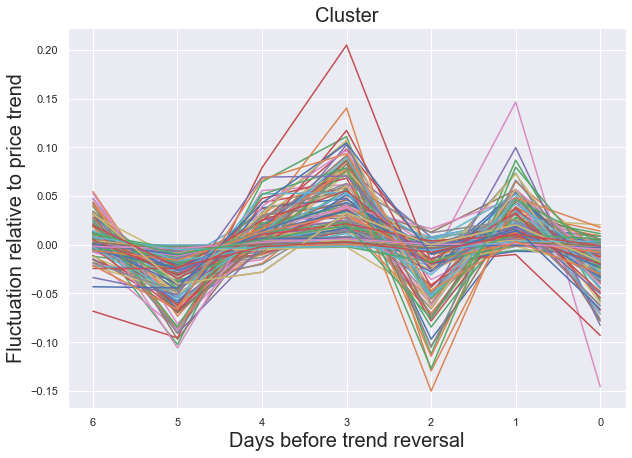

In [102]:
true_direction = small_patterns(cluster[1])
counter = 0
true_cluster = []
plt.title("Cluster", fontsize=20)
plt.ylabel("Fluctuation relative to price trend", fontsize=20)
plt.xlabel("Days before trend reversal", fontsize=20)
b = ["6",'5','4','3','2',"1",'0']
for series in cluster:
    if small_patterns(series) == true_direction:
        true_cluster.append(series)
        sns.lineplot(y=series, x=b)
        counter += 1
print(counter)

9


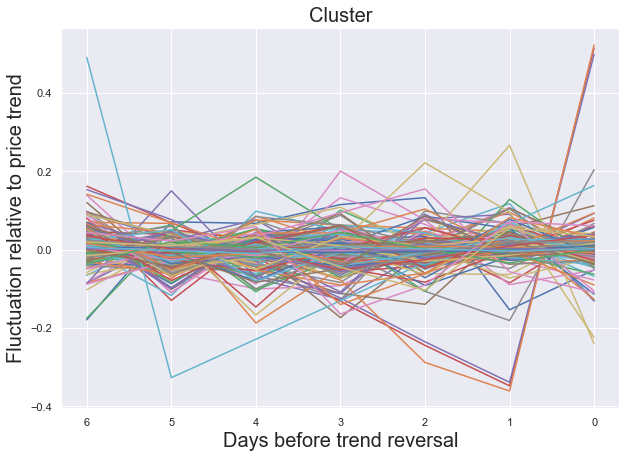

In [117]:
true_direction = small_patterns(cluster[1])
counter = 0
true_cluster = []
plt.title("Cluster", fontsize=20)
plt.ylabel("Fluctuation relative to price trend", fontsize=20)
plt.xlabel("Days before trend reversal", fontsize=20)
b = ["6",'5','4','3','2',"1",'0']
for series in cluster[:200]:
    if small_patterns(series) == true_direction:
        true_cluster.append(series)
        counter += 1
    sns.lineplot(y=series, x=b)
print(counter)

In [94]:
true_motif = generate_motif(true_cluster)

<AxesSubplot:title={'center':'Motif'}, xlabel='Days before trend reversal', ylabel='Fluctuation relative to price trend'>

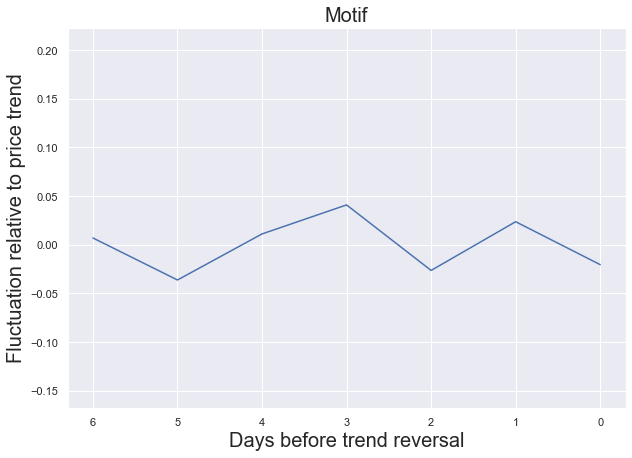

In [115]:
plt.ylim(-0.168, 0.223)
plt.title("Motif", fontsize=20)
plt.ylabel("Fluctuation relative to price trend", fontsize=20)
plt.xlabel("Days before trend reversal", fontsize=20)
b = ["6",'5','4','3','2',"1",'0']
sns.lineplot(y=true_motif, x=b)

In [143]:
type_1_errors = 0 # найден мотив, а точки смены тренда нет
type_2_errors = 0 # точке смены тренда не предшествовал мотив
hits = 0

motif1 = true_motif

window_len = len(motif1) #m_len
legend = 0

df = pd.read_csv('data/test/part_%s.csv' % str(legend))
df = df.drop(labels=['Ticker', 'index', 'Date'], axis=1)
for i in df.index:
    df_temp = df.iloc[[i]]
    df_temp = df_temp.dropna(axis=1)
    series = df_temp.values.tolist()
    if len(series[0]) >= window_len:
        series = detrend(series)
        series = list(np.array(series).flatten())
        series = series[::-1]

        # type 1
        for transposition in range(0, len(series) - window_len - 1):
            # transposition is a pointer, determining what number we transpose the window by
            window = series[transposition:transposition + window_len]
            # мы приложили мотив к window начинающемуся с transposition, 
            # теперь проходимся по точкам window и проверяем, попадают ли они под мотив
            if check_directions(motif1, window) and check_boundaries_euclidean(motif1, window):
                type_1_errors += 1
                print("type 1 on series ", i, " , on transposition ", transposition, len(series))


        # type 2 
        transposition = len(series) - window_len
        window = series[transposition:transposition + window_len]
        if check_directions(motif1, window) and check_boundaries_euclidean(motif1, window):
            hits += 1
            print("hit on series ", i, len(series))
        else:
            type_2_errors += 1

type 1 on series  36  , on transposition  21 284
type 1 on series  95  , on transposition  33 184
type 1 on series  108  , on transposition  101 143
type 1 on series  185  , on transposition  2 49
type 1 on series  377  , on transposition  84 230
type 1 on series  454  , on transposition  13 111
type 1 on series  497  , on transposition  94 190
type 1 on series  514  , on transposition  34 49
type 1 on series  517  , on transposition  21 32
type 1 on series  522  , on transposition  165 184
type 1 on series  547  , on transposition  116 268
type 1 on series  625  , on transposition  35 223
type 1 on series  641  , on transposition  33 247
type 1 on series  652  , on transposition  28 221
type 1 on series  675  , on transposition  62 223
type 1 on series  696  , on transposition  71 116
type 1 on series  719  , on transposition  142 252
type 1 on series  730  , on transposition  57 95
type 1 on series  774  , on transposition  222 270
type 1 on series  803  , on transposition  62 254
ty

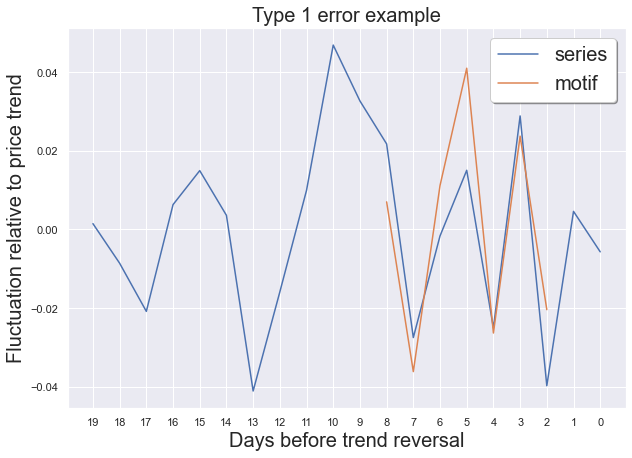

In [137]:
# type_1_series = [0.0014701866036674338, -0.008594944477763933, -0.020835810266612298, 0.006305886386885562, 0.014952932067234637, 0.0035822647971319177, -0.04107866932399559, -0.015895229271394695, 0.009940931193431701, 0.04687400621563487, 0.03267474077955762, 0.02173926813304919, -0.02749099496631846, -0.0016548345014923554, 0.015042858735296205, -0.025048794089701745, 0.02885572688201582, -0.03973948107346779, 0.004591330364507408, -0.0056913741876654655]
type_1_series =plt.title("Type 1 error example", fontsize=20)
plt.ylabel("Fluctuation relative to price trend", fontsize=20)
plt.xlabel("Days before trend reversal", fontsize=20)

x_1 = [str(x) for x in list(range(len(type_1_series)))[::-1]]
x_2 = [str(x) for x in list(range(len(type_1_series)))[::-1][11:11+len(motif1)]]

sns.lineplot(y=type_1_series, x=x_1, label = 'series').legend(shadow = True,fontsize = 20, facecolor = 'white')
sns.lineplot(y=motif1, x=x_2, label = 'motif').legend(shadow = True,fontsize = 20, facecolor = 'white')

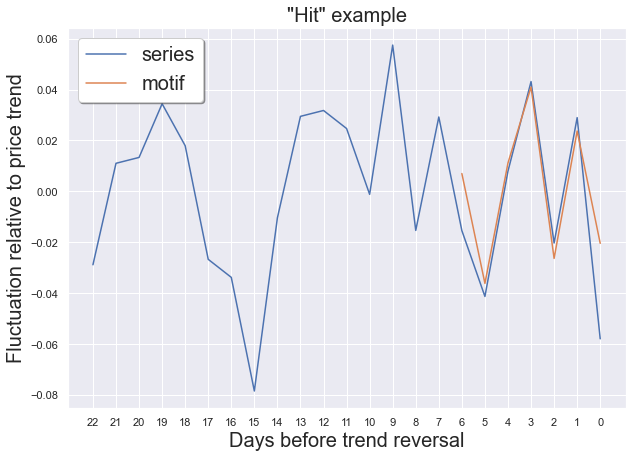

In [139]:
hit_series = [-0.028832398946970206, 0.011031951632786141, 0.013337563374729244, 0.03442258930902131, 0.017948965952383156, -0.02669377869277756, -0.03377778450012536, -0.07842043959840328, -0.010387057277007394, 0.029477293302748953, 0.031782905044692056, 0.024698899237344474, -0.0011644312154683312, 0.05747924400975324, -0.01533244283016344, 0.029226761297679815, -0.0154159833474809, -0.04127931380029326, 0.007974743875637125, 0.04314424090730634, -0.020277783609877587, 0.028976229292611094, -0.057919973418124715]

plt.title("\"Hit\" example", fontsize=20)
plt.ylabel("Fluctuation relative to price trend", fontsize=20)
plt.xlabel("Days before trend reversal", fontsize=20)

x_1 = [str(x) for x in list(range(len(hit_series)))[::-1]]
x_2 = [str(x) for x in list(range(len(hit_series)))[::-1][len(hit_series)-len(motif1):]]

sns.lineplot(y=hit_series, x=x_1, label = 'series').legend(shadow = True,fontsize = 20, facecolor = 'white')
sns.lineplot(y=motif1, x=x_2, label = 'motif').legend(shadow = True,fontsize = 20, facecolor = 'white')

0.07002048259145151


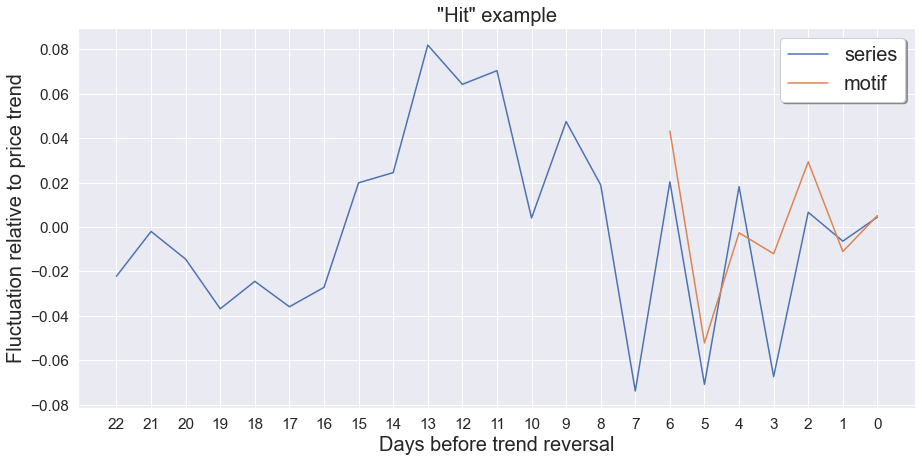

In [184]:
hit_series = detrend_flat([0.5647780618733831, 0.5580421118006282, 0.5186629954945741, 0.4694393716966148, 0.4549312133221589, 0.4165884638788939, 0.3984534560200501, 0.4186610889706284, 0.3963809395621585, 0.4269514807037236, 0.3823909646190979, 0.3616651482371251, 0.2683989745182482, 0.2849797579844382, 0.2295381502774317, 0.1098466856004589, 0.1772055345249483, 0.0590684571913944, 0.1212458520203908, 0.0088084665306457, 0.0559596281876358, 0.0160624370840304, 0.0])

plt.title("\"Hit\" example", fontsize=20)
plt.ylabel("Fluctuation relative to price trend", fontsize=20)
plt.xlabel("Days before trend reversal", fontsize=20)

motif2 = [0.04326661382864386,
   -0.05219169704939639,
   -0.002559443581860041,
   -0.01204702327887493,
   0.029392349609203852,
   -0.011047052779223607,
   0.00518625325150738]

x_1 = [str(x) for x in list(range(len(hit_series)))[::-1]]
x_2 = [str(x) for x in list(range(len(hit_series)))[::-1][len(hit_series)-len(motif2):]]

sns.lineplot(y=hit_series, x=x_1, label = 'series').legend(shadow = True,fontsize = 20, facecolor = 'white')
sns.lineplot(y=motif2, x=x_2, label = 'motif').legend(shadow = True,fontsize = 20, facecolor = 'white')
print(euclidean(hit_series[-7:], motif2))

<AxesSubplot:title={'center':'Metrics comparison for different approaches'}, xlabel='Approach', ylabel='Silhouette score'>

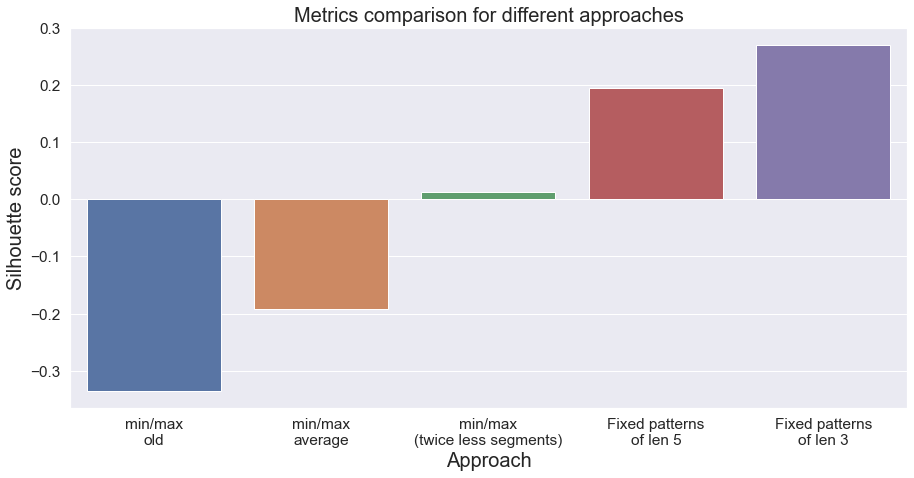

In [180]:
dic = {"min/max\nold":-0.335068,
      "min/max\naverage":-0.19188,
      "min/max\n(twice less segments)":np.mean([-0.05820,0.06038,0.0347]),
      "Fixed patterns\nof len 5":0.1938976112768608,
      "Fixed patterns\nof len 3":0.269815}

plt.title("Metrics comparison for different approaches", fontsize=20)
plt.ylabel("Silhouette score", fontsize=20)
plt.xlabel("Approach", fontsize=20)

sns.barplot(x=list(dic), y=list(dic.values()))

<AxesSubplot:>

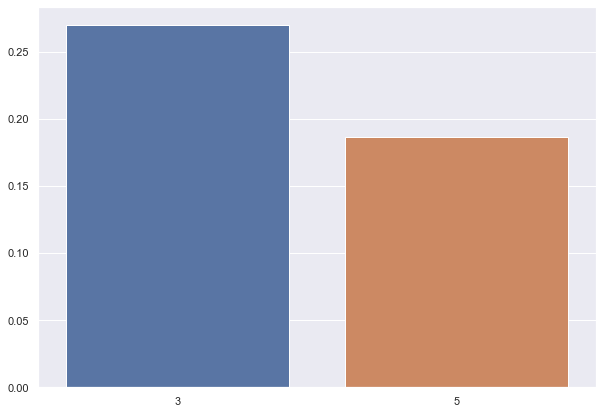

In [163]:
dic = {"3":0.269815, # length of patterns
      "5":0.186049}

sns.barplot(x=list(dic), y=list(dic.values()))